# 2D-CNNs for MNIST dataset
* Learn about:
    * [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)
    * Coding with PyTorch Lightning
        * LightningDataModule
        * LightningModule
        * (optional) Logger, Trainer, callbacks
    * Two types of the artificial neuralnetworks
        * Multilayer perceptron (MLP)
        * 2D Convolutional neuralnetworks (2D CNNs)
* Let's try:
    * Build MLP or CNNs by yourself
    * Try to use other loss functions
    * Try to change the training parameters
        * learning rate, batch size, epochs, etc...

## Step1. Lightning data module for MNIST dataset ##

* `train_data`: 50,000
* `test_data`: 10,000
* `val_data`: 10,000

In [1]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np

from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from typing import Optional



In [2]:
class HKDataset(LightningDataModule):
    def __init__(
        self,
        batch_size: int = 128,
        num_workers: int = 2,
        ):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mean = ()
        self.std = ()
        self.trans = None

    def setup(self, stage: Optional[str] = None) -> None:
        imgs = torch.load('../hyperk_img/imgs_scaled.pt')
        labels_targets = torch.load('../hyperk_img/labels_targets_scaled.pt')
        indices = torch.load('../hyperk_img/indices.pt')

        self.train_data = torch.utils.data.TensorDataset( imgs[indices['train']], labels_targets[indices['train']])
        self.valid_data = torch.utils.data.TensorDataset( imgs[indices['valid']], labels_targets[indices['valid']])
        self.test_data = torch.utils.data.TensorDataset( imgs[indices['test']], labels_targets[indices['test']])

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)
    

## Step2-2. 2D-CNNs model ##

In [3]:
from torch import nn

class CNNs2D(nn.Module):
    def __init__(self):
        super(CNNs2D, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        
        self.fc_class_layer = nn.Sequential(
            nn.Linear(1024,2), # 2class
            nn.Softmax(dim=1)
        )
        self.fc_regression_layer = nn.Sequential(
            nn.Linear(1024, 4), # 4 regression targets
            nn.Tanh()
        )
    def forward(self, x):
        #print('x0', x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        #print('x4', x.shape, x)
        return [self.fc_class_layer(x), self.fc_regression_layer(x)]

## Step3. Pytorch lightning module ##

In [4]:
from torch.nn import functional as F
from torch import optim
from torch import Tensor
from torchmetrics.classification import BinaryAccuracy
from pytorch_lightning import LightningModule


class PLModuleMNIST(LightningModule):
    def __init__(self, model, lr_rate):
        super(PLModuleMNIST, self).__init__()
        self.model = model
        self.lr_rate = lr_rate
        self.accuracy_calc = BinaryAccuracy(threshold=0.5)
        
        self.automatic_optimization = False
        self.loss_training = []
        self.loss_valid = []
        self.loss_training_epoch = []
        self.loss_valid_epoch = []
        
        self.acc_training = []
        self.acc_valid = []
        self.acc_training_epoch = []
        self.acc_valid_epoch = []

    def forward(self, batch: Tensor, **kwargs) -> Tensor:
        #print('batch:', batch.size)
        return self.model(batch)

    #def loss_fn(self, x, y):
    #    #print('loss:x,y',x.shape, y.shape)
    #    #print('type',x[0].dtype, y[0].dtype)
    #    return F.nll_loss(x, y)
    
    #def loss_fn_regression(self, x, y):
    #    #print(x[0][0], y[0][0])
    #    loss_energy = F.l1_loss(x[:,0], y[:,0])
    #    loss_position = F.l1_loss(x[:,1:4], y[:,1:4])
    #    loss = loss_energy + loss_position
    #    return loss
    
    def loss_fn(self, x, y):
        x_class=x[0]
        y_class=torch.tensor(y[:,0], dtype=torch.int64)
        x_reg=x[1]
        y_reg=y[:,1:]
        
        loss_class = F.nll_loss(x_class, y_class)
        loss_energy = F.l1_loss(x_reg[:,0], y_reg[:,0])
        loss_position = F.l1_loss(x_reg[:,1:4], y_reg[:,1:4])
        loss = loss_class + loss_energy + loss_position
        
        return loss

    def training_step(self, batch):
        opt = self.optimizers()
        opt.zero_grad()
        
        x, y = batch
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        
        acc = self.accuracy_calc(logits[0][:,1], label)
        
        self.manual_backward(loss)
        opt.step()

        self.loss_training.append(loss)
        self.acc_training.append(acc)        

        
    def validation_step(self, batch):
        x, y = batch
        
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        #print('val:x,y', x.shape, y.shape)
        #print('type',type(x), type(y))
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        acc = self.accuracy_calc(logits[0][:,1], label)
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        #acc = self.accuracy_calc(logits, y[:,0])
        self.loss_valid.append(loss)
        self.acc_valid.append(acc)

    
    def test_step(self, batch):
        x, y = batch
        label=torch.tensor(y[:,0], dtype=torch.int64)
        #targets=y[:,1:5]
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        acc = self.accuracy_calc(x[1], label)
        
        #loss = self.loss_fn(logits,y[:,0])
        #loss = self.loss_fn_regression(logits,targets)
        #acc = self.accuracy_calc(logits, y[:,0])

    
    def on_train_epoch_end(self) -> None:
        avg_loss = torch.stack(self.loss_training).mean()
        avg_acc = torch.stack(self.acc_training).mean()
        self.loss_training.clear()
        self.acc_training.clear()
        #print('train_loss:', avg_loss, 'train_acc', avg_acc)
        self.loss_training_epoch.append(avg_loss)
        self.acc_training_epoch.append(avg_acc)
        self.log('loss/train',avg_loss)
        self.log('acc/train',avg_acc)

    def on_validation_epoch_end(self) -> None:
        avg_loss = torch.stack(self.loss_valid).mean()
        avg_acc = torch.stack(self.acc_valid).mean()
        self.loss_valid.clear()
        self.acc_valid.clear()
        self.loss_valid_epoch.append(avg_loss)
        self.acc_valid_epoch.append(avg_acc)
        self.log('loss/valid',avg_loss)
        self.log('acc/valid',avg_acc)


    def configure_optimizers(self):
        optimizer =  optim.Adam(self.parameters(), lr=self.lr_rate)
        lr_scheduler = {'scheduler': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9), 'name': 'exp_LR'}
        return [optimizer], [lr_scheduler]
        #return optim.Adam(self.model.parameters(), lr=0.001)

## Step4. Logger ##
Tensorboard logger is used. A window of tensorboard opens here.

In [5]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir='./tb_logs/', name = 'HK')


#%reload_ext tensorboard
#%tensorboard --logdir=./tb_logs/

## Step5. Build & fit a model ##
Select whether to use `MLP()` or `CNNs2D()` for the model. The settings for the learning is described here.
* `lr_rate`: learning rate
* `batch_size`
* `max_epochs`

In [6]:
model_core = CNNs2D() # or MLP()
#model_core = MLP()
model = PLModuleMNIST(model = model_core, lr_rate=0.001)
dm = HKDataset(batch_size=128)

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar

runner = Trainer(max_epochs=50, 
                 #gpus=[0],
                 accelerator='cpu',  # or 'gpu', 'auto'
                 logger=logger, 
                 callbacks=[TQDMProgressBar(refresh_rate=10)])


runner.fit(model, dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shingo/work/hyperk/ml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/tmp/ipykernel_582999/3446991305.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glo

/tmp/ipykernel_582999/1433470696.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(y[:,0], dtype=torch.int64)
/tmp/ipykernel_582999/1433470696.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_class=torch.tensor(y[:,0], dtype=torch.int64)


Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s] 

/tmp/ipykernel_582999/1433470696.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(y[:,0], dtype=torch.int64)


Epoch 49: 100%|██████████| 79/79 [00:09<00:00,  8.76it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 79/79 [00:09<00:00,  8.74it/s, v_num=8]


## Step6. Check the trained model ##
* Structure of the model
* Classification performance for the test dataset
* Feature maps

#### Step6-1. Structure of the trained model ####

In [8]:
## You can load the trained model at the specific checkpoint
#model = PLModuleMNIST.load_from_checkpoint(model=model_core, lr_rate=0.001, checkpoint_path='./tb_logs/MNIST/version_0/checkpoints/epoch=2-step=1173.ckpt')

print(model)

PLModuleMNIST(
  (model): CNNs2D(
    (conv1): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (fc_class_layer): Sequential(
      (0): Linear(in_features=1024, out_features=2, bias=True)
      (1): Softmax(dim=1)
    )
    (fc_regression_layer): Sequential(
      (0): Linear(in_features=1024, out_features=4, bias=True)


In [13]:
model.eval()
#dm.setup() # when you load the model from a checkpoint

labels_targets = []
#outputs = []
outputs_class = []
outputs_targets = []
for batch in dm.test_dataloader():
    x, y = batch 
    
    outputs = model.model(x)
    out_class = outputs[0].to('cpu').detach()
    out_targets =  outputs[1].to('cpu').detach()
    outputs_class.append(out_class)
    outputs_targets.append(out_targets)
    labels_targets.append(y.to('cpu').detach())
    

In [14]:
labels_targets=np.vstack(labels_targets)
outputs_class=np.vstack(outputs_class)
outputs_targets=np.vstack(outputs_targets)



In [15]:


torch.save(labels_targets, 'test_labels_targets.pt')
torch.save(outputs_class, 'test_outputs_class.pt')
torch.save(outputs_targets, 'test_outputs_targets.pt')

#### Step6-2. Classification perfromance for the test dataset ####
`Loss` and `Accuracy` are useful metrics for understanding the performance

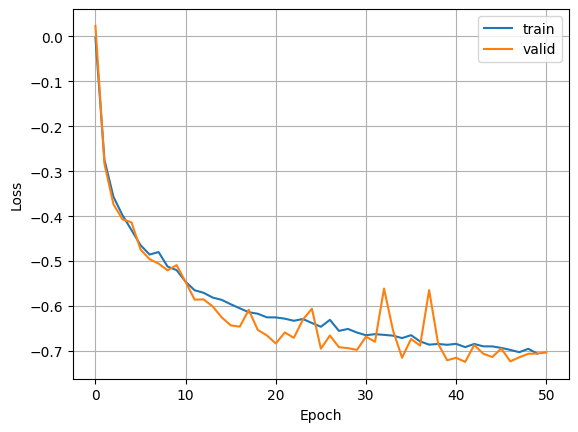

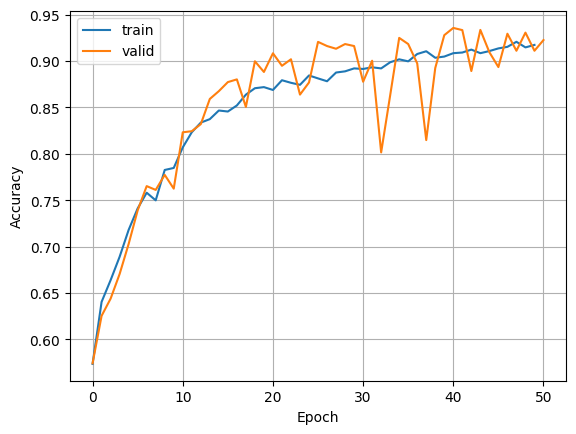

In [12]:
import matplotlib.pyplot as plt
loss_train = [i.to('cpu').detach().numpy() for i in model.loss_training_epoch]
loss_valid = [i.to('cpu').detach().numpy() for i in model.loss_valid_epoch]

plt.plot(loss_train, label='train')
plt.plot(loss_valid, label='valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
#plt.ylim([None, 1])
plt.show()


acc_train = [i.to('cpu').detach().numpy() for i in model.acc_training_epoch]
acc_valid = [i.to('cpu').detach().numpy() for i in model.acc_valid_epoch]

plt.plot(acc_train, label='train')
plt.plot(acc_valid, label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
#plt.ylim([None, 1])
plt.show()